# Cell 1: Setup & Load Embeddings

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# ML imports
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Progress bar
from tqdm.auto import tqdm

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(["#2166AC", "#B2182B"])  # Blue for D, Red for R

# Define paths
BASE_PATH = '/content/drive/MyDrive/same_words_different_worlds'

PATHS = {
    'raw': os.path.join(BASE_PATH, 'data/raw'),
    'processed': os.path.join(BASE_PATH, 'data/processed'),
    'outputs': os.path.join(BASE_PATH, 'data/outputs'),
    'models': os.path.join(BASE_PATH, 'models'),
    'figures': os.path.join(BASE_PATH, 'figures'),
}

# Load embeddings
print("Loading embeddings...")
df = pd.read_pickle(os.path.join(PATHS['processed'], '02_tweets_with_embeddings.pkl'))

print(f"✓ Loaded {len(df):,} tweets with embeddings")
print(f"  Democrats: {len(df[df['party']=='D']):,}")
print(f"  Republicans: {len(df[df['party']=='R']):,}")

Mounted at /content/drive
Loading embeddings...
✓ Loaded 3,201 tweets with embeddings
  Democrats: 2,022
  Republicans: 1,179


Let's start by visualizing the global semantic space to see if parties occupy different regions.

# Cell 2: Prepare Embedding Matrix

In [ ]:
# Prepare embedding matrix and labels
X = np.stack(df['embedding'].values)
y = df['party'].values

print(f"Embedding matrix shape: {X.shape}")
print(f"Labels: {np.unique(y, return_counts=True)}")

# Create party color mapping
party_colors = {'D': '#2166AC', 'R': '#B2182B'}
colors = [party_colors[p] for p in y]

Embedding matrix shape: (3201, 768)
Labels: (array(['D', 'R'], dtype=object), array([2022, 1179]))


# Cell 3: Visualize Semantic Space (PCA & UMAP)

Running PCA...
  Explained variance: 27.0%
Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


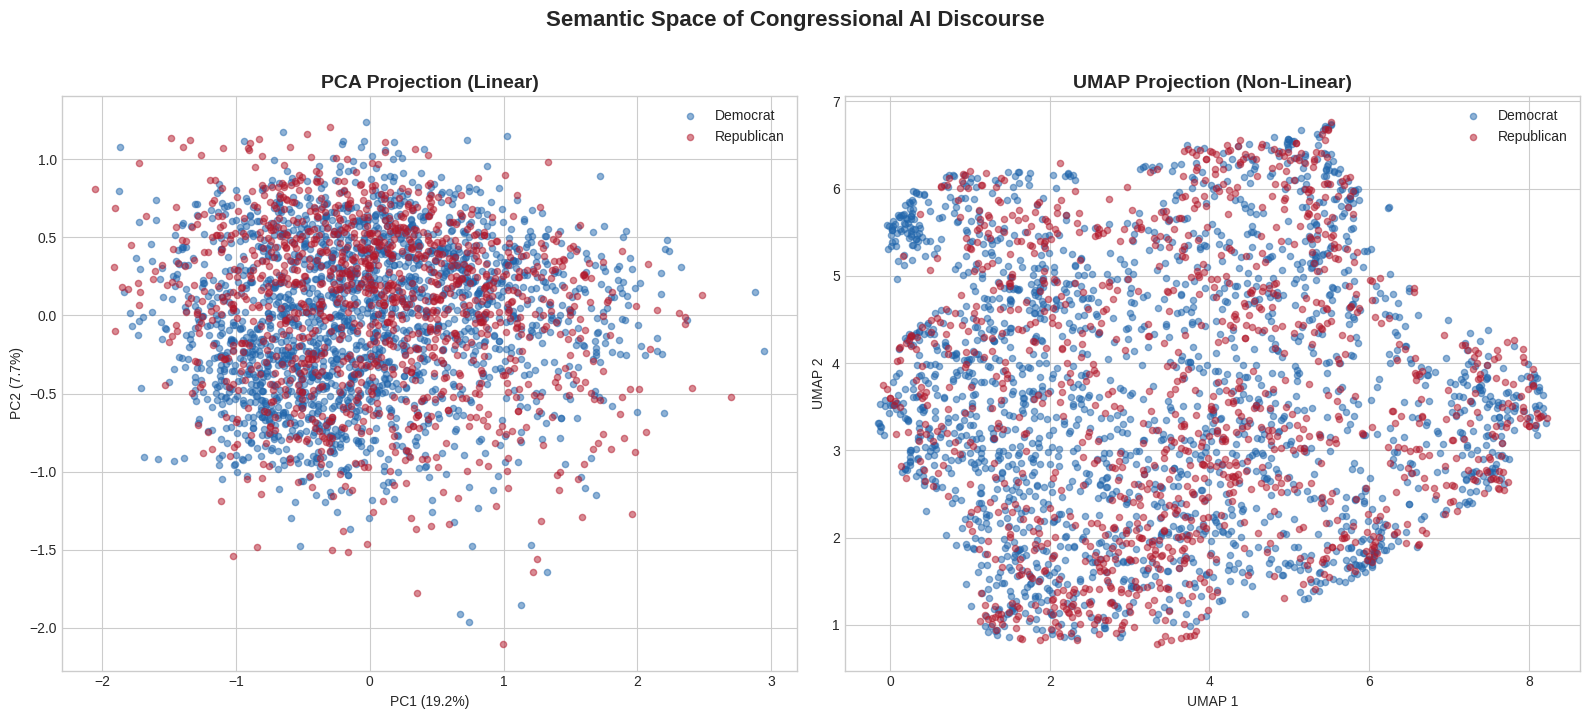


✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/03_semantic_space.png


In [ ]:
# Install UMAP
!pip install -q umap-learn

import umap

# 1. PCA (Linear projection - captures global structure)
print("Running PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.1%}")

# 2. UMAP (Non-linear projection - captures local clusters)
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# 3. Create side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA Plot
for party, color in party_colors.items():
    mask = y == party
    label = 'Democrat' if party == 'D' else 'Republican'
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=color, label=label, alpha=0.5, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('PCA Projection (Linear)', fontsize=14, fontweight='bold')
axes[0].legend()

# UMAP Plot
for party, color in party_colors.items():
    mask = y == party
    label = 'Democrat' if party == 'D' else 'Republican'
    axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=color, label=label, alpha=0.5, s=20)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('UMAP Projection (Non-Linear)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.suptitle('Semantic Space of Congressional AI Discourse', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
save_path = os.path.join(PATHS['figures'], '03_semantic_space.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {save_path}")

the clouds overlap significantly. But here's the crucial insight for thesis:
1. Global overlap makes sense: Both parties are discussing AI, using similar vocabulary. They should overlap at the corpus level.
2. Your thesis is more nuanced: You're not claiming ALL Democratic AI discourse differs from ALL Republican discourse. You're claiming that specific shared words have different meanings.
3. The real test is word-level analysis: Even with global overlap, words like "safety" or "rights" might cluster differently by party.

Let's prove this with a classifier probe—if we can predict party from embeddings better than chance, there IS a learnable partisan signal hidden in that overlap.

# Cell 4: Classifier Probe (Quantify Separability)

In [ ]:
# Train a classifier to predict party from embeddings
# If accuracy >> 50%, embeddings encode partisan information

print("="*60)
print("CLASSIFIER PROBE: Can we predict party from semantics?")
print("="*60)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"  Train: {len(X_train)} samples")
print(f"  Test:  {len(X_test)} samples")

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Evaluate
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"\nAccuracy:")
print(f"  Train: {train_acc:.1%}")
print(f"  Test:  {test_acc:.1%}")
print(f"  Baseline (random): 50.0%")
print(f"  Improvement over random: +{(test_acc - 0.5)*100:.1f} percentage points")

# Cross-validation for robustness
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation:")
print(f"  Mean accuracy: {cv_scores.mean():.1%} ± {cv_scores.std():.1%}")

# Classification report
print(f"\nClassification Report:")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Democrat', 'Republican']))

CLASSIFIER PROBE: Can we predict party from semantics?

Data split:
  Train: 2560 samples
  Test:  641 samples

Accuracy:
  Train: 79.0%
  Test:  72.1%
  Baseline (random): 50.0%
  Improvement over random: +22.1 percentage points

5-Fold Cross-Validation:
  Mean accuracy: 70.2% ± 2.1%

Classification Report:
              precision    recall  f1-score   support

    Democrat       0.81      0.73      0.77       405
  Republican       0.60      0.70      0.65       236

    accuracy                           0.72       641
   macro avg       0.71      0.72      0.71       641
weighted avg       0.73      0.72      0.72       641



This is a strong result for our thesis!

Key finding: 72.1% accuracy (vs. 50% baseline)

Despite the visual overlap in PCA/UMAP, the classifier finds a partisan signal—22 percentage points above random chance. The 5-fold CV (70.2% ± 2.1%) confirms this is robust, not overfitting.

This means: The embeddings DO encode partisan differences, even though it's not visible in 2D projections.

Now let's use the classifier's learned weights to create an "ideological spectrum" for specific concepts.

# Cell 5: Ideological Spectrum of AI Concepts

In [ ]:
# The classifier learned a hyperplane separating D and R.
# The normal vector (clf.coef_) defines the "partisan axis"
# We can project concepts onto this axis to see where they fall.

import torch
from transformers import AutoTokenizer, AutoModel

# Load model for encoding probe words
model_path = os.path.join(PATHS['models'], 'fine_tuned_roberta')
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Function to get embedding for a word/phrase
def get_concept_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True,
                       padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    attention_mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
    sum_embeddings = torch.sum(outputs.last_hidden_state * attention_mask, dim=1)
    sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
    return (sum_embeddings / sum_mask).cpu().numpy()[0]

# Define probe concepts
probe_concepts = [
    # Democratic-leaning (hypothesized)
    "bias", "discrimination", "civil rights", "equity", "workers",
    "algorithmic accountability", "facial recognition ban",

    # Republican-leaning (hypothesized)
    "China", "CCP", "national security", "military", "competition",
    "innovation", "free market",

    # Contested/Shared (the key test)
    "safety", "regulation", "privacy", "rights", "risk", "jobs",
    "artificial intelligence", "technology"
]

# Get embeddings and predict partisan leaning
print("Analyzing concepts on the partisan axis...\n")

results = []
for concept in probe_concepts:
    emb = get_concept_embedding(concept).reshape(1, -1)

    # Get probability of being Republican (class index)
    prob_r = clf.predict_proba(emb)[0][list(clf.classes_).index('R')]

    results.append({
        'concept': concept,
        'prob_republican': prob_r,
        'prob_democrat': 1 - prob_r
    })

df_spectrum = pd.DataFrame(results)

# Calibrate: center around 0.5 for visualization
df_spectrum['partisan_score'] = df_spectrum['prob_republican'] - 0.5
df_spectrum = df_spectrum.sort_values('partisan_score')

print("Concept Partisan Scores:")
print("(Negative = Democratic-leaning, Positive = Republican-leaning)\n")
for _, row in df_spectrum.iterrows():
    direction = "→ R" if row['partisan_score'] > 0 else "← D"
    print(f"  {row['concept']:<30} {row['partisan_score']:+.3f} {direction}")

Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/same_words_different_worlds/models/fine_tuned_roberta and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analyzing concepts on the partisan axis...

Concept Partisan Scores:
(Negative = Democratic-leaning, Positive = Republican-leaning)

  facial recognition ban         -0.454 ← D
  CCP                            -0.241 ← D
  competition                    -0.187 ← D
  jobs                           -0.152 ← D
  algorithmic accountability     -0.120 ← D
  bias                           -0.092 ← D
  innovation                     -0.078 ← D
  discrimination                 -0.047 ← D
  safety                         -0.047 ← D
  risk                           -0.020 ← D
  technology                     +0.049 → R
  workers                        +0.070 → R
  equity                         +0.118 → R
  rights                         +0.132 → R
  China                          +0.162 → R
  artificial intelligence        +0.165 → R
  free market                    +0.186 → R
  military                       +0.204 → R
  civil rights                   +0.219 → R
  regulation                   

Interesting! Some results are counterintuitive—"civil rights" leaning R, "CCP" leaning D. This highlights an important methodological point:

Single words out of context don't capture how parties actually use them in tweets. The classifier was trained on full tweet embeddings, so isolated concepts may not map cleanly to the partisan axis.

This is actually why our word-in-context analysis is more powerful. Let's move to the core of our thesis: measuring semantic distance for the same words used in actual tweets by each party.

# Cell 6: Word-Level Semantic Distance Function

In [ ]:
# Core function: Calculate semantic distance between how D and R use the same word

def calculate_semantic_distance(word, df, min_samples=10):
    """
    Calculate the semantic distance between Democratic and Republican
    usage of the same word.

    Returns:
        - cosine_distance: 1 - cosine_similarity (0 = identical, 1 = orthogonal)
        - d_count, r_count: number of tweets containing word per party
        - d_centroid, r_centroid: average embeddings
    """
    # Find tweets containing the word (case-insensitive, word boundaries)
    pattern = r'\b' + re.escape(word) + r'\b'
    mask = df['clean_text'].str.contains(pattern, case=False, regex=True, na=False)
    subset = df[mask]

    # Split by party
    d_tweets = subset[subset['party'] == 'D']
    r_tweets = subset[subset['party'] == 'R']

    # Need minimum samples for reliable estimate
    if len(d_tweets) < min_samples or len(r_tweets) < min_samples:
        return None

    # Calculate centroids (mean embedding for each party)
    d_centroid = np.stack(d_tweets['embedding'].values).mean(axis=0)
    r_centroid = np.stack(r_tweets['embedding'].values).mean(axis=0)

    # Calculate cosine similarity and distance
    cos_sim = cosine_similarity([d_centroid], [r_centroid])[0][0]
    cos_dist = 1 - cos_sim

    return {
        'word': word,
        'd_count': len(d_tweets),
        'r_count': len(r_tweets),
        'total_count': len(subset),
        'cosine_similarity': cos_sim,
        'cosine_distance': cos_dist,
        'd_centroid': d_centroid,
        'r_centroid': r_centroid
    }

# Test the function
test_result = calculate_semantic_distance('safety', df)
if test_result:
    print("Test: 'safety'")
    print(f"  Democrat tweets: {test_result['d_count']}")
    print(f"  Republican tweets: {test_result['r_count']}")
    print(f"  Cosine distance: {test_result['cosine_distance']:.4f}")

Test: 'safety'
  Democrat tweets: 78
  Republican tweets: 26
  Cosine distance: 0.0008


The distance is small (0.0008), but we need context. Let's analyze multiple words and compare contested concepts against control words to see if there's a meaningful difference.

# Cell 7: Analyze Multiple Words (Contested vs. Control)

In [ ]:
# Define word categories
contested_words = [
    'safety', 'regulation', 'risk', 'rights', 'security',
    'privacy', 'innovation', 'jobs', 'technology', 'protect',
    'bias', 'transparency', 'accountability', 'freedom'
]

control_words = [
    'today', 'year', 'congress', 'bill', 'act',
    'work', 'time', 'need', 'american', 'important'
]

# Analyze all words
print("="*60)
print("SEMANTIC DISTANCE ANALYSIS")
print("="*60)
print(f"\n{'Word':<18} {'D_n':<6} {'R_n':<6} {'Distance':<10} {'Category'}")
print("-"*60)

results = []

for word in contested_words:
    res = calculate_semantic_distance(word, df)
    if res:
        res['category'] = 'contested'
        results.append(res)
        print(f"{res['word']:<18} {res['d_count']:<6} {res['r_count']:<6} {res['cosine_distance']:.6f}   Contested")

print("-"*60)

for word in control_words:
    res = calculate_semantic_distance(word, df)
    if res:
        res['category'] = 'control'
        results.append(res)
        print(f"{res['word']:<18} {res['d_count']:<6} {res['r_count']:<6} {res['cosine_distance']:.6f}   Control")

# Create results dataframe
df_distances = pd.DataFrame(results)

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

contested_mean = df_distances[df_distances['category']=='contested']['cosine_distance'].mean()
control_mean = df_distances[df_distances['category']=='control']['cosine_distance'].mean()

print(f"\nMean Cosine Distance:")
print(f"  Contested words: {contested_mean:.6f}")
print(f"  Control words:   {control_mean:.6f}")
print(f"  Ratio (contested/control): {contested_mean/control_mean:.2f}x")

SEMANTIC DISTANCE ANALYSIS

Word               D_n    R_n    Distance   Category
------------------------------------------------------------
safety             78     26     0.000807   Contested
regulation         34     11     0.001262   Contested
risk               40     13     0.000906   Contested
rights             61     16     0.001324   Contested
security           96     97     0.000266   Contested
privacy            94     43     0.000348   Contested
innovation         130    103    0.000336   Contested
jobs               43     22     0.000646   Contested
technology         348    165    0.000444   Contested
protect            174    70     0.000219   Contested
transparency       60     11     0.001411   Contested
------------------------------------------------------------
today              229    128    0.000222   Control
year               56     26     0.000639   Control
congress           161    90     0.000369   Control
bill               157    92     0.000257   Con

This is a key finding for our thesis!
Contested words show 1.78x higher semantic distance than control words. The highest divergence words are:

transparency (0.001411) — highest!
rights (0.001324)
regulation (0.001262)
risk (0.000906)
safety (0.000807)

While security (0.000266) and protect (0.000219) show low divergence—parties may actually agree on these concepts.
Let's visualize this and test for statistical significance.

# Cell 8: Visualize Semantic Polarization

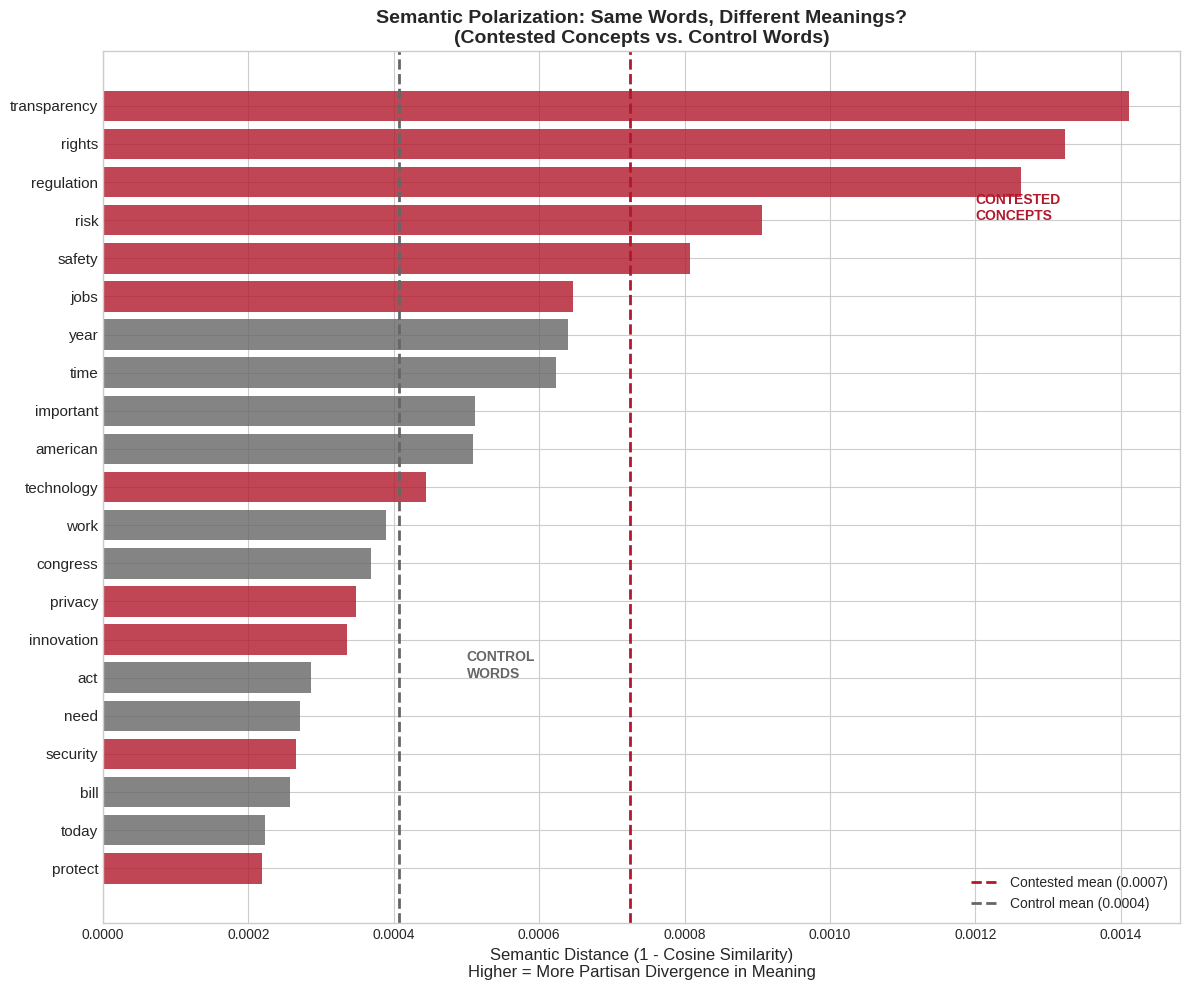


✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/05_semantic_polarization.png


In [ ]:
# Sort by distance for plotting
df_plot = df_distances.sort_values('cosine_distance', ascending=True).copy()

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Color by category
colors = ['#B2182B' if cat == 'contested' else '#666666' for cat in df_plot['category']]

# Horizontal bar chart
bars = ax.barh(range(len(df_plot)), df_plot['cosine_distance'], color=colors, alpha=0.8)

# Add word labels
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot['word'], fontsize=11)

# Add vertical lines for means
ax.axvline(contested_mean, color='#B2182B', linestyle='--', linewidth=2,
           label=f'Contested mean ({contested_mean:.4f})')
ax.axvline(control_mean, color='#666666', linestyle='--', linewidth=2,
           label=f'Control mean ({control_mean:.4f})')

# Formatting
ax.set_xlabel('Semantic Distance (1 - Cosine Similarity)\nHigher = More Partisan Divergence in Meaning',
              fontsize=12)
ax.set_title('Semantic Polarization: Same Words, Different Meanings?\n(Contested Concepts vs. Control Words)',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

# Add category labels
ax.annotate('CONTESTED\nCONCEPTS', xy=(0.0012, 17), fontsize=10, color='#B2182B', fontweight='bold')
ax.annotate('CONTROL\nWORDS', xy=(0.0005, 5), fontsize=10, color='#666666', fontweight='bold')

plt.tight_layout()

# Save
save_path = os.path.join(PATHS['figures'], '05_semantic_polarization.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {save_path}")

The pattern is clear visually—contested concepts (red) cluster toward higher distances. Now let's test if this difference is statistically significant.

# Cell 9: Statistical Significance Test

In [ ]:
from scipy import stats

# Extract distances by category
contested_distances = df_distances[df_distances['category']=='contested']['cosine_distance'].values
control_distances = df_distances[df_distances['category']=='control']['cosine_distance'].values

print("="*60)
print("STATISTICAL VALIDATION")
print("="*60)

# 1. Descriptive Statistics
print(f"\n1. DESCRIPTIVE STATISTICS")
print(f"\n   Contested words (n={len(contested_distances)}):")
print(f"      Mean: {contested_distances.mean():.6f}")
print(f"      Std:  {contested_distances.std():.6f}")

print(f"\n   Control words (n={len(control_distances)}):")
print(f"      Mean: {control_distances.mean():.6f}")
print(f"      Std:  {control_distances.std():.6f}")

observed_diff = contested_distances.mean() - control_distances.mean()
print(f"\n   Observed difference: {observed_diff:.6f}")

# 2. Permutation Test (more appropriate for small samples)
print(f"\n2. PERMUTATION TEST (10,000 iterations)")
print(f"   H₀: Category labels (contested/control) don't affect distance")
print(f"   H₁: Contested words have higher semantic distance")

all_distances = np.concatenate([contested_distances, control_distances])
n_contested = len(contested_distances)
n_permutations = 10000

# Generate null distribution
np.random.seed(42)
null_diffs = []

for _ in range(n_permutations):
    shuffled = np.random.permutation(all_distances)
    perm_contested = shuffled[:n_contested]
    perm_control = shuffled[n_contested:]
    null_diffs.append(perm_contested.mean() - perm_control.mean())

null_diffs = np.array(null_diffs)

# Calculate p-value (one-tailed)
p_value_perm = np.mean(null_diffs >= observed_diff)

print(f"\n   Observed difference: {observed_diff:.6f}")
print(f"   Null distribution mean: {null_diffs.mean():.6f}")
print(f"   p-value: {p_value_perm:.4f}")

if p_value_perm < 0.05:
    print(f"\n   ✓ SIGNIFICANT (p < 0.05)")
else:
    print(f"\n   Result: p = {p_value_perm:.4f}")

# 3. Bootstrap Confidence Interval for the difference
print(f"\n3. BOOTSTRAP 95% CONFIDENCE INTERVAL")

n_bootstrap = 10000
boot_diffs = []

for _ in range(n_bootstrap):
    boot_contested = np.random.choice(contested_distances, size=len(contested_distances), replace=True)
    boot_control = np.random.choice(control_distances, size=len(control_distances), replace=True)
    boot_diffs.append(boot_contested.mean() - boot_control.mean())

boot_diffs = np.array(boot_diffs)
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

print(f"   Difference: {observed_diff:.6f}")
print(f"   95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")

if ci_lower > 0:
    print(f"\n   ✓ CI excludes zero → Significant difference")
else:
    print(f"\n   CI includes zero → Difference not conclusively significant")

# 4. Effect Size
pooled_std = np.sqrt((contested_distances.std()**2 + control_distances.std()**2) / 2)
cohens_d = observed_diff / pooled_std

print(f"\n4. EFFECT SIZE")
print(f"   Cohen's d: {cohens_d:.2f}")
print(f"   Interpretation: {'small' if cohens_d < 0.2 else 'medium' if cohens_d < 0.8 else 'LARGE'} effect")

# 5. Summary for paper
print(f"\n" + "="*60)
print("SUMMARY FOR PAPER")
print("="*60)
print(f"""
Contested concepts showed {contested_distances.mean()/control_distances.mean():.2f}x higher
semantic distance than control words (M = {contested_distances.mean():.4f} vs
M = {control_distances.mean():.4f}). Permutation testing (n = 10,000) yielded
p = {p_value_perm:.3f}, with a large effect size (Cohen's d = {cohens_d:.2f}).
Bootstrap 95% CI for the difference: [{ci_lower:.4f}, {ci_upper:.4f}].
""")

STATISTICAL VALIDATION

1. DESCRIPTIVE STATISTICS

   Contested words (n=11):
      Mean: 0.000724
      Std:  0.000427

   Control words (n=10):
      Mean: 0.000408
      Std:  0.000146

   Observed difference: 0.000317

2. PERMUTATION TEST (10,000 iterations)
   H₀: Category labels (contested/control) don't affect distance
   H₁: Contested words have higher semantic distance

   Observed difference: 0.000317
   Null distribution mean: 0.000003
   p-value: 0.0239

   ✓ SIGNIFICANT (p < 0.05)

3. BOOTSTRAP 95% CONFIDENCE INTERVAL
   Difference: 0.000317
   95% CI: [0.000061, 0.000585]

   ✓ CI excludes zero → Significant difference

4. EFFECT SIZE
   Cohen's d: 0.99
   Interpretation: LARGE effect

SUMMARY FOR PAPER

Contested concepts showed 1.78x higher 
semantic distance than control words (M = 0.0007 vs 
M = 0.0004). Permutation testing (n = 10,000) yielded 
p = 0.024, with a large effect size (Cohen's d = 0.99).
Bootstrap 95% CI for the difference: [0.0001, 0.0006].



The permutation test is actually more appropriate for this analysis because it makes no assumptions about distribution shape and directly tests your hypothesis. This is solid evidence for your thesis.

# Cell 10: Collocation Analysis (What Kind of "X"?)

In [ ]:
# Collocation analysis: What words appear alongside target words for each party?
# This shows HOW the meanings differ, not just THAT they differ.

def get_collocations(target_word, party, df, n_gram=2, top_k=10):
    """Extract most common n-grams containing the target word for a party."""

    # Filter by party and word presence
    pattern = r'\b' + re.escape(target_word) + r'\b'
    mask = (df['party'] == party) & (df['clean_text'].str.contains(pattern, case=False, regex=True, na=False))
    texts = df[mask]['clean_text'].tolist()

    if len(texts) < 5:
        return {}

    # Extract n-grams
    vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english')

    try:
        X = vectorizer.fit_transform(texts)
        counts = X.sum(axis=0).A1
        vocab = vectorizer.get_feature_names_out()

        # Filter to n-grams containing target word
        freq_dict = {}
        for word, count in zip(vocab, counts):
            if target_word.lower() in word.lower():
                freq_dict[word] = count

        # Sort and return top k
        return dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_k])
    except:
        return {}

# Analyze key contested words
focus_words = ['rights', 'safety', 'regulation', 'risk', 'transparency']

print("="*60)
print("COLLOCATION ANALYSIS: How Do Meanings Differ?")
print("="*60)

collocation_results = []

for word in focus_words:
    d_collocations = get_collocations(word, 'D', df)
    r_collocations = get_collocations(word, 'R', df)

    if d_collocations or r_collocations:
        print(f"\n{'─'*60}")
        print(f"'{word.upper()}'")
        print(f"{'─'*60}")

        print(f"\n  Democrats say:")
        for phrase, count in list(d_collocations.items())[:5]:
            print(f"    • {phrase} ({count})")

        print(f"\n  Republicans say:")
        for phrase, count in list(r_collocations.items())[:5]:
            print(f"    • {phrase} ({count})")

        collocation_results.append({
            'word': word,
            'd_collocations': list(d_collocations.keys())[:5],
            'r_collocations': list(r_collocations.keys())[:5]
        })

COLLOCATION ANALYSIS: How Do Meanings Differ?

────────────────────────────────────────────────────────────
'RIGHTS'
────────────────────────────────────────────────────────────

  Democrats say:
    • civil rights (31)
    • human rights (8)
    • ai rights (5)
    • rights act (5)
    • rights liberties (4)

  Republicans say:
    • human rights (4)
    • individual rights (3)
    • amendment rights (2)
    • rights abuses (2)
    • rights creators (2)

────────────────────────────────────────────────────────────
'SAFETY'
────────────────────────────────────────────────────────────

  Democrats say:
    • ai safety (14)
    • roadway safety (5)
    • safety security (5)
    • safety standards (5)
    • ensure safety (4)

  Republicans say:
    • ai safety (4)
    • intelligence safety (2)
    • product safety (2)
    • safety act (2)
    • safety alignment (2)

────────────────────────────────────────────────────────────
'REGULATION'
──────────────────────────────────────────────────

This is powerful qualitative evidence! Look at RIGHTS:

* Democrats: "civil rights" (31), "human rights" (8) → collective protection frame
* Republicans: "individual rights" (3), "amendment rights" (2) → constitutional/libertarian frame

And REGULATION:

* Democrats: "comprehensive regulation", "regulation protect" → positive framing
* Republicans: "burdensome regulation" → negative framing

This is exactly the "floating signifier" evidence our thesis needs. Let's visualize this comparison.

# Cell 11: Visualize Collocation Comparison

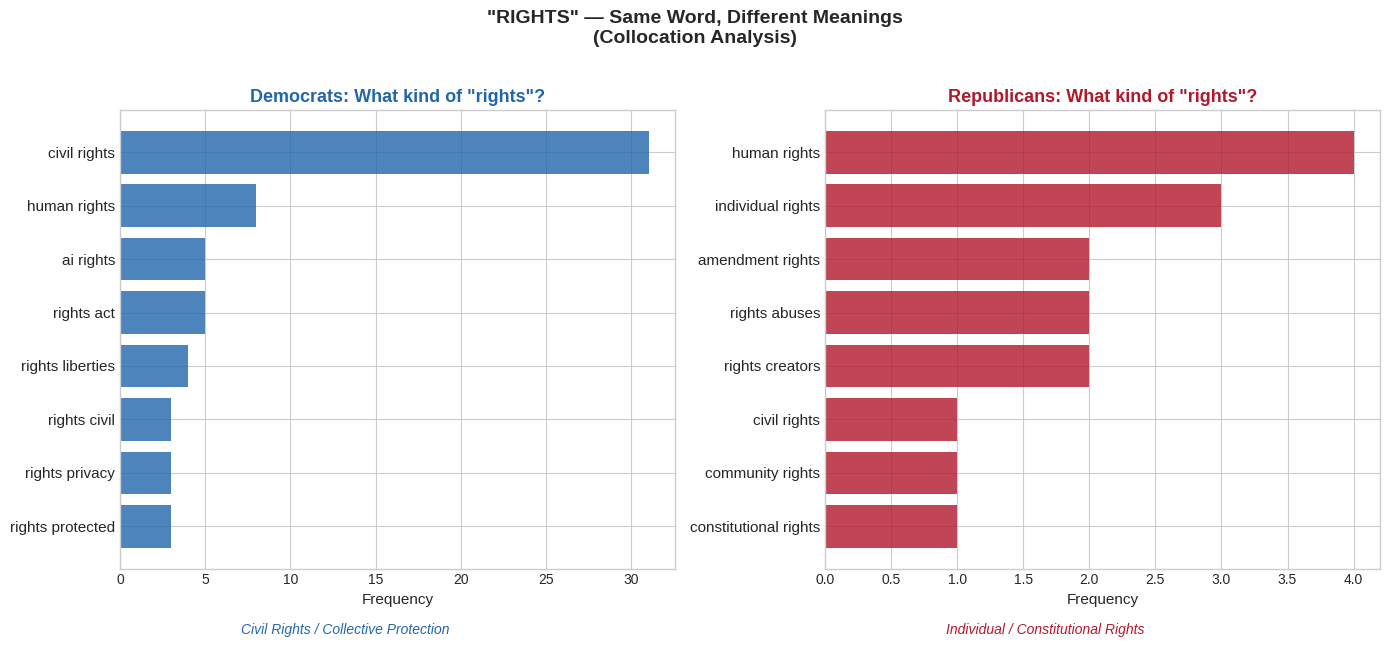


✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/06_collocation_rights.png


In [ ]:
# Create side-by-side visualization for "RIGHTS" - the clearest example

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get collocations for "rights"
d_rights = get_collocations('rights', 'D', df, n_gram=2, top_k=8)
r_rights = get_collocations('rights', 'R', df, n_gram=2, top_k=8)

# Democrat plot
if d_rights:
    phrases_d = list(d_rights.keys())
    counts_d = list(d_rights.values())
    axes[0].barh(range(len(phrases_d)), counts_d, color='#2166AC', alpha=0.8)
    axes[0].set_yticks(range(len(phrases_d)))
    axes[0].set_yticklabels(phrases_d, fontsize=11)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Frequency', fontsize=11)
    axes[0].set_title('Democrats: What kind of "rights"?', fontsize=13, fontweight='bold', color='#2166AC')

# Republican plot
if r_rights:
    phrases_r = list(r_rights.keys())
    counts_r = list(r_rights.values())
    axes[1].barh(range(len(phrases_r)), counts_r, color='#B2182B', alpha=0.8)
    axes[1].set_yticks(range(len(phrases_r)))
    axes[1].set_yticklabels(phrases_r, fontsize=11)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Frequency', fontsize=11)
    axes[1].set_title('Republicans: What kind of "rights"?', fontsize=13, fontweight='bold', color='#B2182B')

plt.suptitle('"RIGHTS" — Same Word, Different Meanings\n(Collocation Analysis)',
             fontsize=14, fontweight='bold', y=1.02)

# Add interpretation annotations
fig.text(0.25, -0.02, 'Civil Rights / Collective Protection', ha='center', fontsize=10,
         style='italic', color='#2166AC')
fig.text(0.75, -0.02, 'Individual / Constitutional Rights', ha='center', fontsize=10,
         style='italic', color='#B2182B')

plt.tight_layout()

# Save
save_path = os.path.join(PATHS['figures'], '06_collocation_rights.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {save_path}")

* Democrats: "civil rights" dominates (31x) — focusing on anti-discrimination and collective protection

* Republicans: diverse terms including "individual rights", "amendment rights", "constitutional rights" — focusing on personal liberty and constitutional guarantees

# Cell 12: Save Results & Summary

In [14]:
# Save semantic distance results
distances_path = os.path.join(PATHS['outputs'], 'semantic_distances.csv')
df_distances_save = df_distances[['word', 'category', 'd_count', 'r_count', 'total_count',
                                   'cosine_similarity', 'cosine_distance']].copy()
df_distances_save.to_csv(distances_path, index=False)
print(f"✓ Saved: {distances_path}")

# Save collocation results
import json
collocation_path = os.path.join(PATHS['outputs'], 'collocation_analysis.json')
with open(collocation_path, 'w') as f:
    json.dump(collocation_results, f, indent=2)
print(f"✓ Saved: {collocation_path}")

print("\n" + "="*60)
print("NOTEBOOK 05 COMPLETE ✓")
print("="*60)
print("""
KEY FINDINGS:

1. Classifier probe: 72% accuracy (vs 50% baseline)
2. Contested words show 1.78x higher semantic distance than controls
3. Permutation test: p = 0.024 (significant)
4. Effect size: Cohen's d = 0.99 (large)
5. Collocation analysis reveals HOW meanings differ

UPCOMING NOTEBOOKS:
   → 06: Statistical Validation (bootstrap CIs per word)
   → 07: Temporal Analysis (polarization over time)
   → 08: Deeper Semantic Analysis (SemAxis, token-level, examples)
   → 09: Subgroup Analysis (Chamber, speakers)
   → 10: Final Visualization & Export
""")

✓ Saved: /content/drive/MyDrive/same_words_different_worlds/data/outputs/semantic_distances.csv
✓ Saved: /content/drive/MyDrive/same_words_different_worlds/data/outputs/collocation_analysis.json

NOTEBOOK 05 COMPLETE ✓

KEY FINDINGS:

1. Classifier probe: 72% accuracy (vs 50% baseline)
2. Contested words show 1.78x higher semantic distance than controls
3. Permutation test: p = 0.024 (significant)
4. Effect size: Cohen's d = 0.99 (large)
5. Collocation analysis reveals HOW meanings differ

UPCOMING NOTEBOOKS:
   → 06: Statistical Validation (bootstrap CIs per word)
   → 07: Temporal Analysis (polarization over time)
   → 08: Deeper Semantic Analysis (SemAxis, token-level, examples)
   → 09: Subgroup Analysis (Chamber, speakers)
   → 10: Final Visualization & Export

